In [53]:
import random
import numpy as np
import pygame
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Game Constants
WIDTH, HEIGHT = 400, 400
GRID_SIZE = 25

# Directions
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

def get_random_position():
    x = random.randint(0, (WIDTH // GRID_SIZE) - 1) * GRID_SIZE
    y = random.randint(0, (HEIGHT // GRID_SIZE) - 1) * GRID_SIZE
    return x, y


In [54]:
class SnakeGame:
    def __init__(self):
        self.frame_count = 0
        self.episode = 0
        self.window = None
        self.clock = None
        self.reset()

    def reset(self):
        self.snake = [(WIDTH // 2, HEIGHT // 2)]
        self.direction = random.choice([UP, DOWN, LEFT, RIGHT])
        self.food = get_random_position()
        self.score = 0
        self.init_render()
        return self.get_state()

    def init_render(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("Snake RL")
            self.clock = pygame.time.Clock()

    def render(self, delay=30):
        self.window.fill((0, 0, 0))  # background
        for seg in self.snake:
            pygame.draw.rect(self.window, (0, 255, 0), (seg[0], seg[1], GRID_SIZE, GRID_SIZE))  # Snake: green
        pygame.draw.rect(self.window, (255, 0, 0), (self.food[0], self.food[1], GRID_SIZE, GRID_SIZE))  # Food: red
        pygame.display.flip()
        self.clock.tick(60)
        pygame.time.delay(delay)

    def close(self):
        if self.window:
            pygame.quit()
            self.window = None
    
    def step(self, action):
        prev_distance = self.get_distance_to_food()
        
        turn_left = {UP: LEFT, LEFT: DOWN, DOWN: RIGHT, RIGHT: UP}
        turn_right = {UP: RIGHT, RIGHT: DOWN, DOWN: LEFT, LEFT: UP}

        if action == 0:  # turn left
            self.direction = turn_left[self.direction]
        elif action == 2:  # turn right
            self.direction = turn_right[self.direction]
        
        self.frame_count += 1
        if self.frame_count > 100 * len(self.snake):  # or tweak the multiplier
            done = True
            reward = -20  # or lower to push agent to act

        head_x, head_y = self.snake[0]
        if self.direction == UP:
            head_y -= GRID_SIZE
        elif self.direction == DOWN:
            head_y += GRID_SIZE
        elif self.direction == LEFT:
            head_x -= GRID_SIZE
        elif self.direction == RIGHT:
            head_x += GRID_SIZE
        
        new_head = (head_x, head_y)
        self.snake.insert(0, new_head)
        
        reward = 0
        done = False
        
        # After moving, calculate the new distance
        new_distance = self.get_distance_to_food()

        # Calculate the distance difference
        distance_diff = prev_distance - new_distance

        # Define a scaling factor (e.g., max_distance can be based on your grid size)
        max_distance = WIDTH + HEIGHT  # Maximum possible Manhattan distance
        # Normalize the distance change
        normalized_diff = distance_diff / max_distance

        # Apply rewards based on the normalized distance change
        if distance_diff > 0:  # Getting closer to food
            reward += 0.5 + (1.5 * normalized_diff)  # Increase reward as it gets closer
        else:  # Moving away from food
            reward -= 0.2

        # Penalty when moving towards walls
        if head_x <= GRID_SIZE and self.direction == LEFT:
            reward -= 2
        elif head_x >= WIDTH - 2 * GRID_SIZE and self.direction == RIGHT:
            reward -= 2
        elif head_y <= GRID_SIZE and self.direction == UP:
            reward -= 2
        elif head_y >= HEIGHT - 2 * GRID_SIZE and self.direction == DOWN:
            reward -= 2
        
        if new_head == self.food:
            self.food = get_random_position()
            self.score += 1
            reward += 300
        else:
            self.snake.pop()
            reward -= 0.1
        
        # Collision detection
        if (head_x < 0 or head_x >= WIDTH or head_y < 0 or head_y >= HEIGHT or new_head in self.snake[1:]):
            done = True
            reward = -30
        
        return self.get_state(), reward, done
    
    def get_state(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food

        # Directions
        dir_up = self.direction == UP
        dir_down = self.direction == DOWN
        dir_left = self.direction == LEFT
        dir_right = self.direction == RIGHT

        # Danger (walls or self)
        def danger(offset_x, offset_y):
            next_x = head_x + offset_x * GRID_SIZE
            next_y = head_y + offset_y * GRID_SIZE
            if (next_x, next_y) in self.snake or not (0 <= next_x < WIDTH and 0 <= next_y < HEIGHT):
                return 1
            return 0

        state = [
            danger(0, -1),  # danger up
            danger(0, 1),   # danger down
            danger(-1, 0),  # danger left
            danger(1, 0),   # danger right

            dir_up,
            dir_down,
            dir_left,
            dir_right,

            (food_x < head_x),  # food left
            (food_x > head_x),  # food right
            (food_y < head_y),  # food up
            (food_y > head_y),  # food down
        ]

        return np.array(state, dtype=int)

    def get_distance_to_food(self):
        head_x, head_y = self.snake[0]
        food_x, food_y = self.food
        return abs(head_x - food_x) + abs(head_y - food_y)

In [55]:
# DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [56]:
class Agent:
    def __init__(self):
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0005
        self.batch_size = 64
        self.memory = deque(maxlen=5000)
        self.model = DQN(12, 3)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)  
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        q_values = self.model(states).gather(1, actions)
        max_next_q_values = self.model(next_states).max(1, keepdim=True)[0].detach()
        target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))
        
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Training Loop
game = SnakeGame()
agent = Agent()

episodes = 6000
scores = []
total_rewards = []
render_every = 1000  # Render every N episodes

for episode in range(episodes):
    state = game.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done = game.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Only render selected episodes
        if episode % render_every == 0 or episode == episodes - 1:
            game.render(delay=20)

    agent.train()
    
    scores.append(game.score)
    total_rewards.append(total_reward)
    
    print(f"Episode {episode + 1}/{episodes} | Score: {game.score} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")

game.close()
torch.save(Agent().model.state_dict(), "snake_dqn.pth")

Episode 1/6000 | Score: 0 | Total Reward: -37.17 | Epsilon: 1.0000
Episode 2/6000 | Score: 0 | Total Reward: -32.59 | Epsilon: 0.9990
Episode 3/6000 | Score: 0 | Total Reward: -32.84 | Epsilon: 0.9980
Episode 4/6000 | Score: 0 | Total Reward: -29.53 | Epsilon: 0.9970
Episode 5/6000 | Score: 0 | Total Reward: -32.58 | Epsilon: 0.9960
Episode 6/6000 | Score: 0 | Total Reward: -40.13 | Epsilon: 0.9950
Episode 7/6000 | Score: 0 | Total Reward: -31.99 | Epsilon: 0.9940
Episode 8/6000 | Score: 0 | Total Reward: -34.48 | Epsilon: 0.9930
Episode 9/6000 | Score: 0 | Total Reward: -37.16 | Epsilon: 0.9920
Episode 10/6000 | Score: 0 | Total Reward: -42.29 | Epsilon: 0.9910
Episode 11/6000 | Score: 0 | Total Reward: -31.36 | Epsilon: 0.9900
Episode 12/6000 | Score: 0 | Total Reward: -38.84 | Epsilon: 0.9891
Episode 13/6000 | Score: 0 | Total Reward: -36.72 | Epsilon: 0.9881
Episode 14/6000 | Score: 0 | Total Reward: -36.17 | Epsilon: 0.9871
Episode 15/6000 | Score: 0 | Total Reward: -36.33 | Epsil

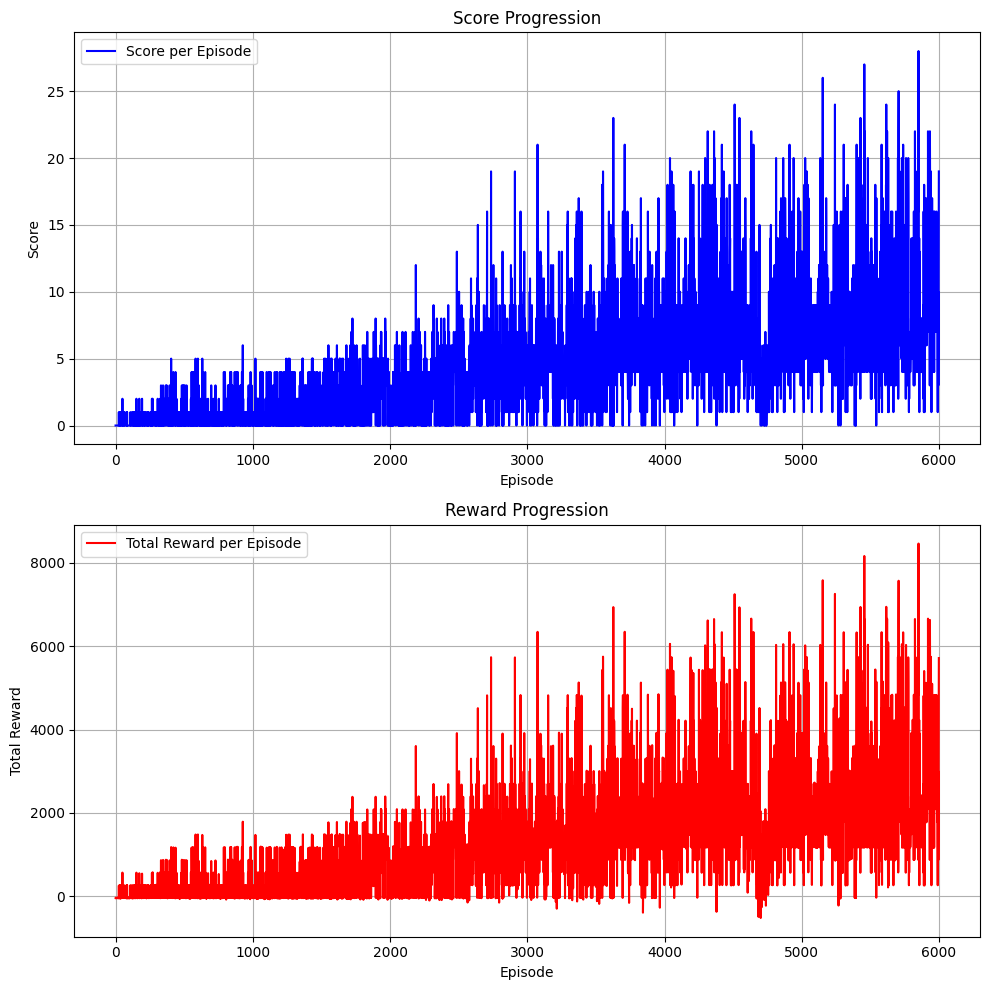

In [58]:
# Plotting Scores and Rewards
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Score Plot
axes[0].plot(scores, label="Score per Episode", color="blue")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Score")
axes[0].set_title("Score Progression")
axes[0].legend()
axes[0].grid()

# Reward Plot
axes[1].plot(total_rewards, label="Total Reward per Episode", color="red")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Total Reward")
axes[1].set_title("Reward Progression")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()